In [0]:
%matplotlib inline

import sys
import pickle as pkl
import theano
import theano.tensor as T
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from warnings import filterwarnings
from pymc3.theanof import set_tt_rng, MRG_RandomStreams

filterwarnings('ignore')
sns.set_style('white')

from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification, load_breast_cancer
from sklearn.base import BaseEstimator, ClassifierMixin

#from sklearn.base import TransformerMixin
#from sklearn.pipeline import Pipeline, FeatureUnion


Simulate some data:

In [2]:
k = 30
N = 10000

# Generate features matrix and target vector
X, Y = make_classification(n_samples = N,
                                       n_features = k,
                                       n_informative = 3,
                                       n_redundant = 0,
                                       n_classes = 2,
                                       weights = [.5, .5],
                                       random_state = 0)

#X = np.insert(X, 0, values = 1, axis=1)

# Partition:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

sc_fit = StandardScaler().fit(X_train)

X_train = sc_fit.transform(X_train)
X_test = sc_fit.transform(X_test)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(800, 10)
(200, 10)
(800,)
(200,)


In [21]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=5000)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3)

sc_fit = StandardScaler().fit(X_train)

X_train = sc_fit.transform(X_train)
X_test = sc_fit.transform(X_test)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(3500, 2)
(1500, 2)
(3500,)
(1500,)


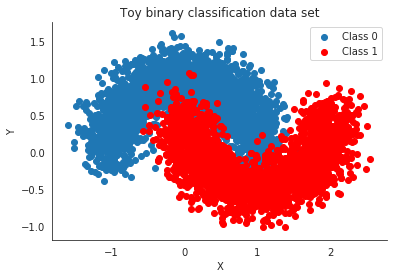

In [0]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [0]:
k = 20
N = 10000

X, Y = make_blobs(n_samples=N, n_features=k, centers=2, cluster_std=1.5, shuffle=True)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

sc_fit = StandardScaler().fit(X_train)

X_train = sc_fit.transform(X_train)
X_test = sc_fit.transform(X_test)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(8000, 20)
(2000, 20)
(8000,)
(2000,)


## Define model class:

In [0]:

class bnn(BaseEstimator, ClassifierMixin):  
  
    """Bayesian 2-hidden layer FNN with informative prior"""

    def __init__(self, dec_thresh = 0.5, bnn_kwargs=None, sample_kwargs=None):
       self.dec_thresh = dec_thresh
       self.bnn_kwargs = bnn_kwargs 
       self.sample_kwargs = sample_kwargs

        
    def fit(self, X, y, ndraws=500, batch_size=None):
        
      self.N, self.K = X.shape
  
      if self.bnn_kwargs is None:
         self.bnn_kwargs = {}

      if self.sample_kwargs is None:
         self.sample_kwargs = {'chains': 2, 'progressbar':True, 'tune': 500}         # use multiple chains to check for convergence

          
      #self.ann_input = pm.Minibatch(X, batch_size=batch_size)
      #self.ann_output = pm.Minibatch(y, batch_size=batch_size)
      
      self.ann_input = theano.shared(X)                    # shared variables so they keep their values between training iterations (updates)
      self.ann_output = theano.shared(y)

      self.model = self.bnn_func(self.ann_input, self.ann_output, **self.bnn_kwargs)

      with self.model:
        
          #self.start = pm.find_MAP()
          #self.inference = pm.NUTS()   
          #self.trace = pm.sample(5000, self.inference, start=self.start)
          
          # fit model via MCMC
          #self.trace = pm.sample(**self.sample_kwargs)
          #self.ppc_draws_train = pm.sample_posterior_predictive(trace = self.trace, samples=500, progressbar=True)
          
        # fit model via MCMC
        #----------------------
        #self.trace = pm.sample(**self.sample_kwargs)
        
        # fit model via variational inference:
        self.inference = pm.ADVI()                   # Note, that this is a mean-field approximation so we ignore correlations in the posterior.
        self.approx = pm.fit(n=50000, method = self.inference)   
        self.trace = self.approx.sample(**self.sample_kwargs)

        
        # sample posterior predictive
        ppc_train = pm.sample_posterior_predictive(self.trace, samples=ndraws, progressbar=True) 
        
        # Use probability of > 0.5 to assume prediction of class 1
        pred_train = ppc_train['out'].mean(axis=0) > 0.5
  
        # sample from prior predictive / marg. likelihood
        #self.marg_like = pm.sample_prior_predictive(samples=500) 
      return ppc_train, pred_train

    
    @staticmethod
    def forward(x, w1, w1_2, w2_out):
        act_1 = T.nnet.relu(pm.math.dot(x, w1))                      # intercept in design matrix -> bias is part of w1
        act_2 = T.nnet.relu(pm.math.dot(act_1, w1_2))
        y = pm.math.sigmoid(pm.math.dot(act_2, w2_out))
        return y       
    
    def bnn_func(self, ann_input, ann_output, n_hidden1 = 5, n_hidden2 = 5):

        # Initialize random weights between each layer    
        init_1 = np.random.randn(self.K, n_hidden1).astype(float)
        init_2 = np.random.randn(n_hidden1, n_hidden2).astype(float)
        init_out = np.random.randn(n_hidden2).astype(float)

        with pm.Model() as model_def:

            # Priors:
            #---------
            lam = 1 # 1e-10               # L1/L2 penalization hyperparameter
            #lam = pm.Gamma(alpha = 2, beta=2, shape=1)
            
            # Weights from input to hidden layer
            #weights_in_1 = pm.Laplace('w_in_1', 0, b = 1/lam, 
            #                         shape=(self.K, n_hidden1), 
            #                         testval = init_1)

            # 2nd hidden layer: Weights from 1st to 2nd layer
            #weights_1_2 = pm.Laplace('w_1_2', 0, b = 1/lam, 
            #                        shape=(n_hidden1, n_hidden2), 
            #                        testval=init_2)
            
            # Weights from hidden layer to output
            #weights_2_out = pm.Laplace('w_2_out', 0, b = 1/lam, 
            #                          shape = (n_hidden2,), 
            #                          testval=init_out)

                        
            weights_in_1 = pm.Normal('w_in_1', 0, sd = 1/lam,   # precision lambda 
                                     shape=(self.K, n_hidden1), 
                                     testval=init_1)

            # 2nd hidden layer: Weights from 1st to 2nd layer
            weights_1_2 = pm.Normal('w_1_2', 0, sd=1/lam, 
                                    shape=(n_hidden1, n_hidden2), 
                                    testval=init_2)

            # Weights from hidden layer to output
            weights_2_out = pm.Normal('w_2_out', 0, sd=1/lam, 
                                      shape = (n_hidden2,), 
                                      testval=init_out)

            # Build neural-network:
            #act_1 = T.nnet.relu(pm.math.dot(ann_input, weights_in_1))
            #act_2 = T.nnet.relu(pm.math.dot(act_1, weights_1_2))
            #act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
            #act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
            #act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

            act_out = bnn.forward(ann_input, weights_in_1, weights_1_2, weights_2_out)
            
            # Binary classification -> Bernoulli likelihood
            out = pm.Bernoulli('out', 
                               act_out,
                               observed=ann_output,    # observed rv
                               total_size=self.N) 
        return model_def

    
    def predict(self, X=None, y=None, **sc):
      
        """Map scores to labels via decision threshold"""      
        
        try:
             getattr(self, "ppc_draws")
             labels_out = (self.ppc_draws['out'].mean(axis=0) > self.dec_thresh)*1   
             print("Using available ppc draws.") 
            
        except AttributeError as e:
             print(e)
             #raise RuntimeError("You must train classifer before predicting data!")
             print("No pp draws available -> draw from pp distr.")
             labels = self.score(X=X, **sc) 
             labels_out = (labels.ppc_draws['out'].mean(axis=0) > self.dec_thresh)*1
        finally:    
             return labels_out

    def score(self, X, y=None, ndraws=500):
      
        """Sample from posterior predictive distr."""
        
        self.ann_input.set_value(X)
        #self.ann_output.set_value(y)
        
        #del self.ppc_draws
        #delattr(self, "ppc_draws")
        
        with self.model:
          self.ppc_draws = pm.sample_posterior_predictive(trace = self.trace, samples = ndraws, progressbar=True)   
          
        print("Sampled from posterior predictive distr.")  
        return self  

In [0]:
b = bnn(sample_kwargs = {'draws' : 5000}, bnn_kwargs = {'n_hidden1' : 30, 'n_hidden2' : 10})       # variational
#b = bnn(sample_kwargs = {'draws' : 1000, 'chains': 1, 'progressbar':True}, bnn_kwargs = {'n_hidden1' : 7, 'n_hidden2' : 5})   # mcmc

In [0]:
#sset_tt_rng(MRG_RandomStreams(42))

In [7]:
draws_train, labels_train = b.fit(X_train, Y_train)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 297.16: 100%|██████████| 50000/50000 [01:23<00:00, 601.17it/s]
Finished [100%]: Average Loss = 297.3
100%|██████████| 500/500 [00:10<00:00, 49.88it/s]


In [0]:
trace = b.trace

In [19]:
%cd '/content/drive/My Drive'

/content/drive/My Drive


In [21]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
!pwd

/content/drive/My Drive/my_datasets


In [24]:
%cd 'my_datasets'                # use %cd operator instead of !cd, the latter changes only temporarily

/content/drive/My Drive/my_datasets


In [26]:
! ls -al

celeba	Fashion-MNIST


In [0]:
DATA_PATH = "/content/drive/my_datasets"

In [0]:
sys.path.append("my_datasets")

In [10]:
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 'my_datasets']

In [27]:
pickle_out = open(DATA_PATH+"/trace.pickle","wb")

pkl.dump(trace, pickle_out)      # save

pickle_out.close()

FileNotFoundError: ignored

In [0]:
infile = open('trace.pickle','rb')
trace_imp = pkl.load(infile)                               # load

In [14]:
type(trace_imp)

pymc3.backends.base.MultiTrace

In [0]:
waic = pm.waic(trace, b.model)                # Widely-applicable Information Criterion

In [10]:
print(waic.WAIC)

445.712438222316


In [0]:
#df_comp_WAIC = pm.compare({b.model: trace, b.model: trace})

In [0]:
# Leave-one-out Cross-validation
loo_cv = pm.loo(trace, b.model)

loo_cv.LOO                          # estimate of point-wise out-of-sample prediction accuracy

1947.74016663476

In [0]:
b.trace.varnames

['w_in_1', 'w_1_2', 'w_2_out']

In [0]:
X_test.shape

(1000, 10)

In [68]:

# rectified linear function:
def Relu(x):
	return max(0.0, x)

def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

  
w1 = trace['w_in_1']  
w12 = trace['w_1_2']
w2 = trace['w_2_out']

  # Numpy:
ReLu, Sigmoid = np.vectorize(Relu), np.vectorize(sigmoid)

avg_ppc = np.zeros((X_test.shape[0], b.sample_kwargs['draws']))

for i in range(b.sample_kwargs['draws']):  
  if i % 1000 == 0:
    print(i)
  act1 = ReLu(np.dot(X_test, w1[i,:,:]))  
  act2 = ReLu(np.dot(act1, w12[i,:,:])) 
  act_out = Sigmoid(np.dot(act2, w2[i,:]))
  avg_ppc[:,i] = act_out
  
print("Finished!")
# https://stuartlacy.co.uk/2019/02/11/modelling-bernoulli-mixture-models-with-dirichlet-processes-in-pymc/

0
1000
2000
3000
4000
Finished!


Check numpy vs Theano:

In [0]:
i = 0
act1 = ReLu(np.dot(X_test, w1[i,:,:]))  
lin2 = np.dot(act1, w12[i,:,:])
act2 = ReLu(np.dot(act1, w12[i,:,:])) 

lin3 = np.dot(act2, w2[i,:])
act_out = Sigmoid(lin3)

In [180]:
act2
#lin2
act_out[:10]
#lin3[:10]
#w2[i,:]

array([0.81802438, 0.5019165 , 0.01864044, 0.99198537, 0.03430839,
       0.88639539, 0.99155315, 0.02690776, 0.57604136, 0.91561621])

In [0]:
act_1_the = T.nnet.relu(T.dot(x_test, w1_the.get_value()[i,:,:])) 

lin2_the = T.dot(act_1_the, w12_the.get_value()[i,:,:])
act_2_the = T.nnet.relu(lin2_the)

lin3_the = T.dot(act_2_the, w2_the.get_value()[i,:])

sigm_the = T.nnet.sigmoid(lin3_the)
act_out_the = sigm_the.eval()

In [181]:
#act_2_the.eval()
#lin2_the.eval()
act_out_the[:10]
#lin3_the.eval()[:10]
#w2_the.get_value()[i,:]

array([0.81802438, 0.5019165 , 0.01864044, 0.99198537, 0.03430839,
       0.88639539, 0.99155315, 0.02690776, 0.57604136, 0.91561621])

In [62]:
# Theano:

x_test = theano.shared(X_test)

w1_the = theano.shared(trace['w_in_1'])
w12_the = theano.shared(trace['w_1_2'])
w2_the = theano.shared(trace['w_2_out'])

avg_ppc = np.zeros((X_test.shape[0], b.sample_kwargs['draws']))

for i in range(b.sample_kwargs['draws']):  
  if i % 1000 == 0:
    print(i)
    
    act_1_the = T.nnet.relu(T.dot(x_test, w1_the.get_value()[i,:,:])) 
    act_2_the = T.nnet.relu(T.dot(act_1_the, w12_the.get_value()[i,:,:]))
    sigm_the = T.nnet.sigmoid(T.dot(act_2_the, w2_the.get_value()[i,:]))
    
    act_out_the = sigm_the.eval()
    avg_ppc[:,i] = act_out_the

0
1000
2000
3000
4000


Average $x_{N+1}$ over posterior draws:

In [0]:
post_pred_class_test = np.apply_along_axis(np.mean,1, avg_ppc)

In [70]:
post_pred_class_test.shape

(2000,)

In [0]:
labels_test = (post_pred_class_test > 0.5)*1                    # predicted labels

In [72]:
avg_ppc.shape

(2000, 5000)

1508


Text(0, 0.5, 'Density')

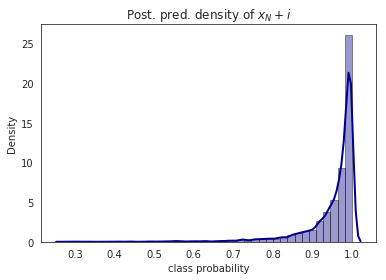

In [73]:
i = np.random.choice(range(0,X_test.shape[0]))

print(i)

sns.distplot(avg_ppc[i,:], hist=True, kde=True, 
             bins=int(200/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

#plt.legend()
plt.title('Post. pred. density of $x_N+i$')
plt.xlabel('class probability')
plt.ylabel('Density')

In [0]:
#max(np.zeros(lin.shape),0)
#np.apply_along_axis(max,1, lin)

In [0]:
#accept = np.sum(trace['Mean of Data'][1:] != trace['Mean of Data'][:-1])
#print("Acceptance Rate: ", accept/trace['Mean of Data'].shape[0])

In [0]:
trace.varnames

['w_in_1', 'w_1_2', 'w_2_out']

In [0]:
trace.get_values(trace.varnames[2]).shape

(5000, 5)

In [0]:
trace.get_values(trace.varnames[0])[:,0,0]

array([ 0.64675631,  0.06917448,  0.55366586, ..., -0.64352438,
       -0.46696141,  0.54669016])

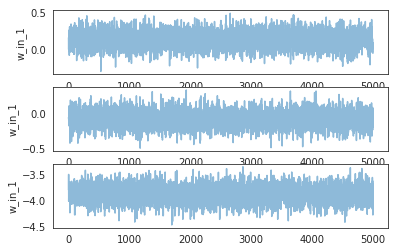

In [83]:
fig, axs = plt.subplots(nrows=3)

axs[0].plot(pd.Series(trace.get_values(trace.varnames[0])[:,0,0], name=trace.varnames[0]), alpha=.5);
axs[0].set(ylabel=trace.varnames[0]);


axs[1].plot(pd.Series(trace.get_values(trace.varnames[0])[:,1,0], name=trace.varnames[0]), alpha=.5);
axs[1].set(ylabel=trace.varnames[0]);

axs[2].plot(pd.Series(trace.get_values(trace.varnames[0])[:,2,0], name=trace.varnames[0]), alpha=.5);
axs[2].set(ylabel=trace.varnames[0]);


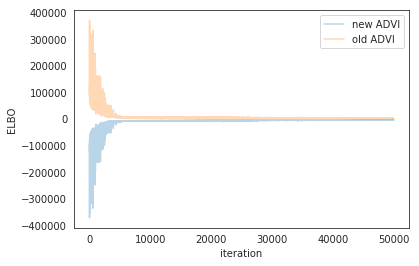

In [74]:
# Plotting the objective function (ELBO) we can see that the optimization slowly improves the fit over time.
plt.plot(-b.inference.hist, label='new ADVI', alpha=.3)
plt.plot(b.approx.hist, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [0]:
#pm.plots.autocorrplot(trace,figsize=(17,5));

In [0]:
# In case of MCMC:
pm.summary(trace)

gw_score = pm.geweke(trace, first=0.1, last=0.5, intervals=20)

pm.gelman_rubin(trace)

ZeroDivisionError: ignored

In [0]:
draws_train.get('out')       # posterior MCMC draws for training data

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [0]:
Y_train.shape

(4000,)

In [0]:
#pm.traceplot(trace,figsize=(20,5));

In [53]:
ppc_train = b.score(X=X_train)   
yhat_train = b.predict() 

100%|██████████| 500/500 [00:13<00:00, 40.33it/s]

Sampled from posterior predictive distr.
Using available ppc draws.


In [54]:
ppc_test = b.score(X=X_test, ndraws=550)   
yhat_test = b.predict() 

100%|██████████| 550/550 [00:15<00:00, 36.30it/s]

Sampled from posterior predictive distr.
Using available ppc draws.


In [55]:
yhat_test[:20]

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0])

In [0]:
#yhat_test.shape
#labels_test.shape

In [75]:
np.mean(np.equal(yhat_test, labels_test))     # passt!

0.9945

In [0]:
pp_draws_train = ppc_train.ppc_draws.get('out')

In [0]:
train_avg_mcmc = ppc_train.ppc_draws.get('out').mean(axis=0)  
test_avg_mcmc = ppc_test.ppc_draws.get('out').mean(axis=0) 

In [60]:
print ("Train accuracy = {:.2f}%".format(100*np.mean(yhat_train == Y_train)))
print ("Test accuracy = {:.2f}%".format(100*np.mean(yhat_test == Y_test)))

Train accuracy = 93.39%
Test accuracy = 93.20%


In [0]:
x1 = train_avg_mcmc
x2 = test_avg_mcmc

colors = ['#E69F00', '#56B4E9']
names = ['Train', 'Test']
         
plt.hist([x1, x2], bins = 30, normed=True,
         color = colors, label=names)

plt.legend()
plt.xlabel('Class probability')
plt.ylabel('Density')
plt.title('Train vs Test post. pred. densities')

Training data - KDE:

Text(0, 0.5, 'Density')

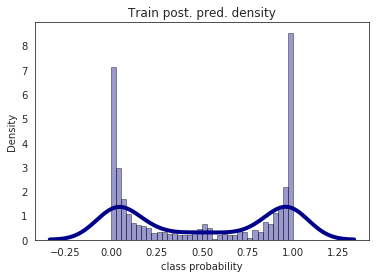

In [0]:
sns.distplot(train_avg_mcmc, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

#plt.legend()
plt.title('Train post. pred. density')
plt.xlabel('class probability')
plt.ylabel('Density')

Test data - KDE:

Text(0, 0.5, 'Density')

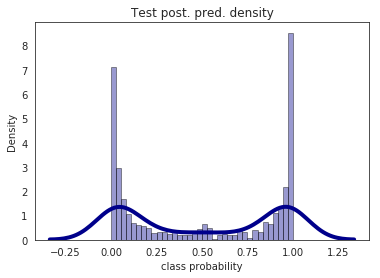

In [0]:
sns.distplot(test_avg_mcmc, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

plt.title('Test post. pred. density')
plt.xlabel('class probability')
plt.ylabel('Density')

In [0]:
Y_test.shape

(1000,)

In [0]:
#fitted.trace
#trace.get_values('w_in_1').shape

#?pm.sample_posterior_predictive
#?pm.sample_prior_predictive

In [0]:
from pymc3 import summary  

summary(b.trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
w_in_1__0_0,-0.043571,0.104450,0.001499,-0.244510,0.163267
w_in_1__0_1,-0.187641,0.133270,0.001884,-0.446359,0.066268
w_in_1__0_2,0.390617,0.532459,0.008040,-0.667996,1.421884
w_in_1__0_3,0.083403,0.067234,0.000924,-0.051256,0.210182
w_in_1__0_4,0.542644,0.158689,0.002262,0.229992,0.854297
w_in_1__0_5,0.124938,0.130651,0.001764,-0.123684,0.382221
w_in_1__0_6,0.120018,0.123498,0.001710,-0.124001,0.362604
w_in_1__1_0,0.058722,0.097126,0.001468,-0.130476,0.246054
w_in_1__1_1,0.173739,0.097106,0.001347,-0.008369,0.364757
w_in_1__1_2,-0.088408,0.539649,0.007097,-1.155627,0.956003


In [0]:
fitted.trace #.get_values['w_in_1']

<MultiTrace: 2 chains, 5000 iterations, 3 variables>